In [1]:
#Define the input layer
import tensorflow as tf 
from tensorflow.keras.layers import Input, Dense, Flatten
import numpy as np
import urllib
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [26]:
#Utils 

def format_output(data): 
  return np.array(data.pop('Y1')), np.array(data.pop('Y2'))

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.legend()
    plt.show()

In [3]:
|#Download the dataset. 
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url) # cool, pandas reads directly from the url.
df = df.sample(frac=1).reset_index(drop=True) # shuffling and removing index.

train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe() #returns a dataframe with stats of the data.

train_stats.pop("Y1")
train_stats.pop("Y2")
train_stats = train_stats.transpose()

train_Y = format_output(train) #pops the y1 and y2 and returns them in a numpy array.
test_Y = format_output(test) #pops the y1 and y2 and returns them in a numpy array.

#Normalize the training and test data. 
norm_train_X = norm(train)
norm_test_X = norm(test)

In [4]:
#Define the model. 
input_ = Input(shape = (len(train.columns),), name= "input") 
dense1 = Dense(units=128, activation='relu', name="dense_1")(input_)
dense2 = Dense(units=128, activation='relu', name="dense_2")(dense1)
#branching 
out1 = Dense(units=1, name="out_1")(dense2) # regression. 
#second branch goes into one more layer of Dense. 
dense3 = Dense(units=64, activation='relu', name="dense_3")(dense2)
out2 = Dense(units=1, name="out_2")(dense3) # regression. 


In [5]:
model = tf.keras.models.Model(inputs = input_, outputs = [out1, out2])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          1152        input[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           8256        dense_2[0][0]                    
______________________________________________________________________________________________

In [6]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001), loss={"out_1" : "mse", "out_2": "mse"}, 
              metrics = {"out_1" : tf.keras.metrics.RootMeanSquaredError(), 
                         "out_2" : tf.keras.metrics.RootMeanSquaredError()})

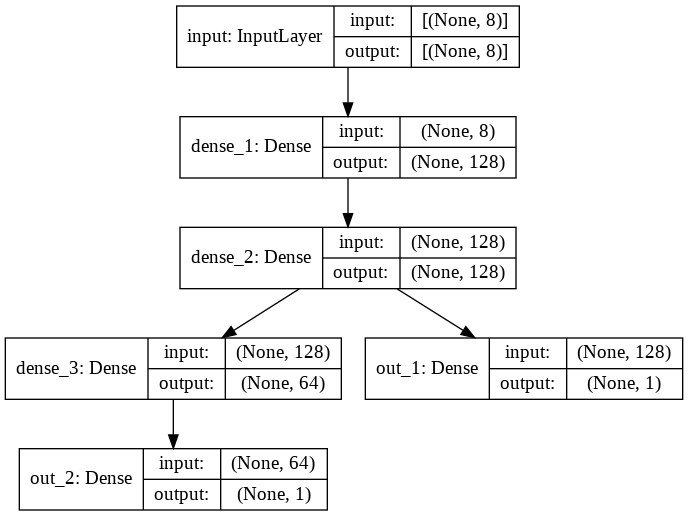

In [7]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [8]:
history = model.fit(norm_train_X, train_Y, epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 9ms/step - loss: 510.9754 - out_1_loss: 252.7955 - out_2_loss: 258.1799 - out_1_root_mean_squared_error: 15.2509 - out_2_root_mean_squared_error: 15.3106 - val_loss: 39.6901 - val_out_1_loss: 13.6814 - val_out_2_loss: 26.0087 - val_out_1_root_mean_squared_error: 3.6988 - val_out_2_root_mean_squared_error: 5.0999
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 32.4972 - out_1_loss: 12.6193 - out_2_loss: 19.8779 - out_1_root_mean_squared_error: 3.5497 - out_2_root_mean_squared_error: 4.4386 - val_loss: 19.5987 - val_out_1_loss: 8.9220 - val_out_2_loss: 10.6767 - val_out_1_root_mean_squared_error: 2.9870 - val_out_2_root_mean_squared_error: 3.2675
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 26.7062 - out_1_loss: 10.1842 - out_2_loss: 16.5220 - out_1_root_mean_squared_error: 3.1895 - out_2_root_mean_squared_error: 4.0614 - val_loss: 20.0368 - val_out_1_loss: 8.9427 - val_out_2_loss

In [9]:
loss, out1_loss, out2_loss, out1_rmse, out2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, out1_loss, out1_rmse, out2_loss, out2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 0.8546 - out_1_loss: 0.2923 - out_2_loss: 0.5622 - out_1_root_mean_squared_error: 0.5407 - out_2_root_mean_squared_error: 0.7498
Loss = 0.8545631170272827, Y1_loss = 0.2923398017883301, Y1_mse = 0.5406845808029175, Y2_loss = 0.5622233748435974, Y2_mse = 0.7498155832290649


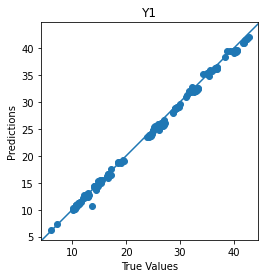

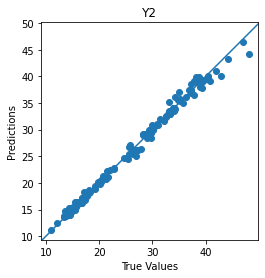

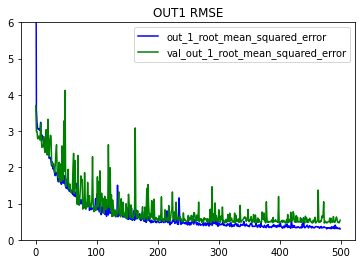

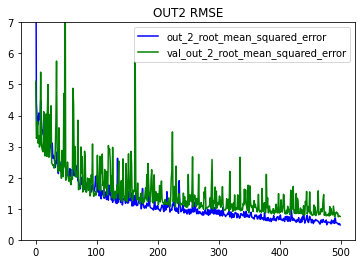

In [13]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='out_1_root_mean_squared_error', title='OUT1 RMSE', ylim=6)
plot_metrics(metric_name='out_2_root_mean_squared_error', title='OUT2 RMSE', ylim=7)